## Sentinel Hub / Xcube Integration Demo
* On-the-fly access to any SentinelHub datasets
* Utilising band / flag mask information
* Utilising external vector / feature data
* Persisting data cube's in user's workspace
* Using Xcube Viewer to visualize generated cubes

We use a NB to demo the user's cube develepment phase ("xcube lab"),
once happy with the result, we can run user's code as 
function-as-a-service, 
either one-time or as a recurring (NRT) service. Use cases:
  
1. simplest case is generate a cube view of SH or access CCI 
   as a cube and download it or store it in DIAS object storage;
2. advanced cases my involve processing EO data to higher levels, 
   perform data-analytics, etc and store the results;
3. in both cases 1 and 2 users may run a publication server so they can 
   also use their web API server and their xcube viewer for the data.
  
---

To run this notebook you need your [Sentinel Hub API authentication](https://docs.sentinel-hub.com/api/latest/#/API/authentication) information and a Python environment
with `xcube` and the xcube plugin `xcube_sh` installed.

Checkout [xcube sources](https://github.com/dcs4cop/xcube) and follow instructions in its [README.md](https://github.com/dcs4cop/xcube/blob/master/README.md).

After activating the `xcube` Python environment, install additional packages required for Sentinel Hub API authentication:

```bash
$ conda activate xcube
(xcube) $ conda install -c conda-forge oauthlib
(xcube) $ pip install requests_oauthlib
```

Then checkout [xcube_sh sources](https://gitext.sinergise.com/dcfs/xcube-dcfs.git) and follow instructions in its [README.md](https://gitext.sinergise.com/dcfs/xcube-dcfs/blob/master/README.md).

Your Sentinel Hub API credentials can be passed as keyword arguments to the `SentinelHub` constructor (see below) or passed as environment variables (preferred): 

```bash
(xcube) $ export SH_CLIENT_ID=<your-id>
(xcube) $ export SH_CLIENT_SECRET=<your-secret>
```

Cd into the `xcube-dcfs` source directory.

Before using Jupyter Lab for the first time install the `jupyterlab` package and make sure the 
[Jupyter GeoJSON extension](https://www.npmjs.com/package/@jupyterlab/geojson-extension) is installed too:

```bash
(xcube) conda install -c conda-forge jupyterlab
(xcube) jupyter labextension install @jupyterlab/geojson-extension
```
Start Jupyter Lab:

```bash
(xcube) $ jupyter-lab
```

In [1]:
import json

import xarray as xr
import shapely.geometry
import IPython.display
import zarr

In [2]:
import xcube.api
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.geodb import GeoDB
from xcube_sh.viewer import ViewerServer

In [3]:
%matplotlib inline

---
For this demo, we are focussing on small coastal area near Kiel, Narth Germany (Baltic Sea)

In [4]:
x1 = 10.00  # degree
y1 = 54.27  # degree
x2 = 11.00  # degree
y2 = 54.60  # degree

bbox = x1, y1, x2, y2

In [5]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Later in this NB we are going to compute some indexes from bands atmospherically corrected bands B04, B05, B06, B11 of Sentinel-2 (S2L2A)
Our time range covers two and a half month of last year's summer: 2018-05-14 to 2018-07-31

The desired resolution is 20 meters per pixel

In [6]:
spatial_res = 0.00018   # = 20.038 meters in degree

In [7]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         chunk_size=[512, 512],
                         geometry=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],
                         time_period='2D')  

In [8]:
# So we can print some SentinelHub usage stats
request_collector = Observers.request_collector()

In [9]:
cube = open_cube(cube_config, request_collector)
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 40)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(40, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), m

Note: a data cube equivalent to `cube` can be generated persistently using the following CLI command: 

```bash
$ xcsh cubify S2L1C -o cube.zarr -b B08 -g 10.237174,53.506205,10.271174,53.540205 -r 6.640625e-05 -t 2017-08-01,2017-08-31 -p 1D
$ python 
>>> import xarray as xr
>>> cube = xr.open_zarr('cube.zarr')
>>> cube
```

In [10]:
cube.time

<xarray.DataArray 'time' (time: 40)>
array(['2018-05-15T00:00:00.000000000', '2018-05-17T00:00:00.000000000',
       '2018-05-19T00:00:00.000000000', '2018-05-21T00:00:00.000000000',
       '2018-05-23T00:00:00.000000000', '2018-05-25T00:00:00.000000000',
       '2018-05-27T00:00:00.000000000', '2018-05-29T00:00:00.000000000',
       '2018-05-31T00:00:00.000000000', '2018-06-02T00:00:00.000000000',
       '2018-06-04T00:00:00.000000000', '2018-06-06T00:00:00.000000000',
       '2018-06-08T00:00:00.000000000', '2018-06-10T00:00:00.000000000',
       '2018-06-12T00:00:00.000000000', '2018-06-14T00:00:00.000000000',
       '2018-06-16T00:00:00.000000000', '2018-06-18T00:00:00.000000000',
       '2018-06-20T00:00:00.000000000', '2018-06-22T00:00:00.000000000',
       '2018-06-24T00:00:00.000000000', '2018-06-26T00:00:00.000000000',
       '2018-06-28T00:00:00.000000000', '2018-06-30T00:00:00.000000000',
       '2018-07-02T00:00:00.000000000', '2018-07-04T00:00:00.000000000',
       '2018-0

We have not yet made any SentinelHub data requests

In [11]:
request_collector.stats

Band metadata also comprises wavelength info

In [12]:
cube.B04

<xarray.DataArray 'B04' (time: 40, lat: 2048, lon: 5632)>
dask.array<zarr, shape=(40, 2048, 5632), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
Attributes:
    sample_type:  FLOAT32
    units:        reflectance
    wavelength:   664.6
    bandwith:     31
    resolution:   10

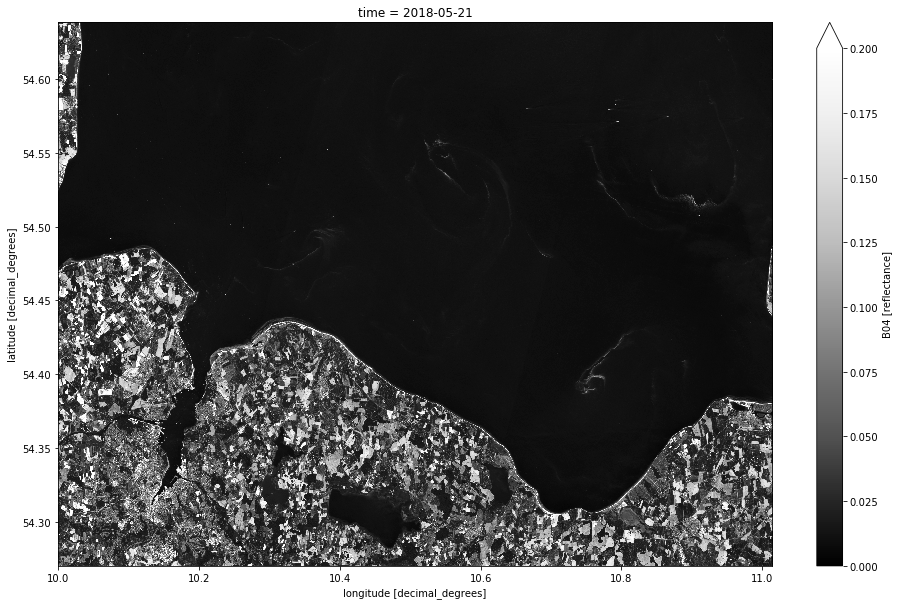

In [13]:
cube.B04.sel(time='2018-05-21').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(16, 10))

Now SentinelHub data requests have been made

In [14]:
request_collector.stats

Scene classification flags have CF-conformant flag encoding information, which xcube can decode

In [15]:
cube.SCL

<xarray.DataArray 'SCL' (time: 40, lat: 2048, lon: 5632)>
dask.array<zarr, shape=(40, 2048, 5632), dtype=uint8, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
Attributes:
    sample_type:    UINT8
    flag_values:    0,1,2,3,4,5,6,7,8,9,10,11
    flag_meanings:  no_data saturated_or_defective dark_area_pixels cloud_sha...

In [16]:
scene_classif = xcube.api.MaskSet(cube.SCL)
scene_classif

xcube mask sets also follow data cube structure

In [17]:
scene_classif.water

<xarray.DataArray 'water' (time: 40, lat: 2048, lon: 5632)>
dask.array<where, shape=(40, 2048, 5632), dtype=uint8, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01

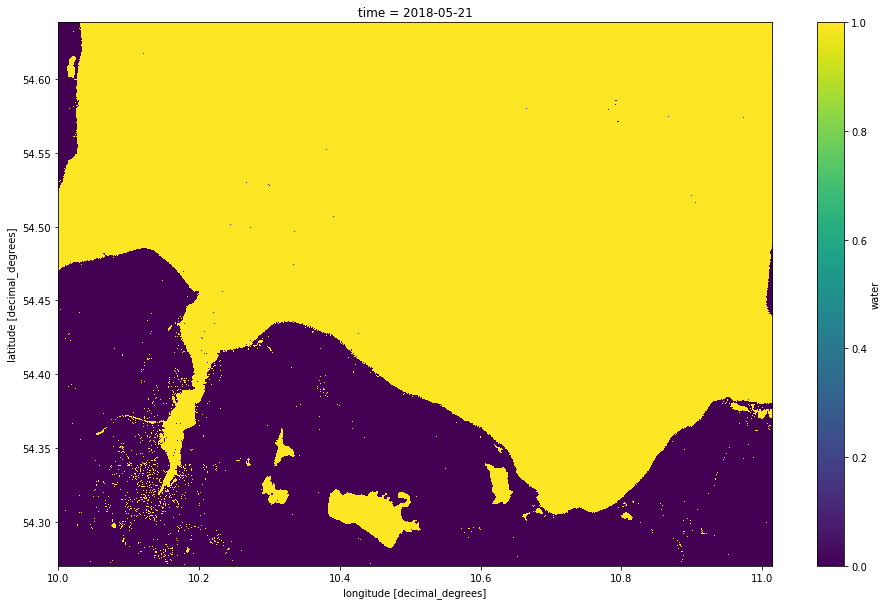

In [18]:
scene_classif.water.sel(time='2018-05-21').plot.imshow(figsize=(16, 10))

In [19]:
request_collector.stats

We can use any of the mask or combinations of it to mask entire cubes. Here we create a "water cube":

In [20]:
water_cube = cube.where(scene_classif.water)
water_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 40)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(40, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512

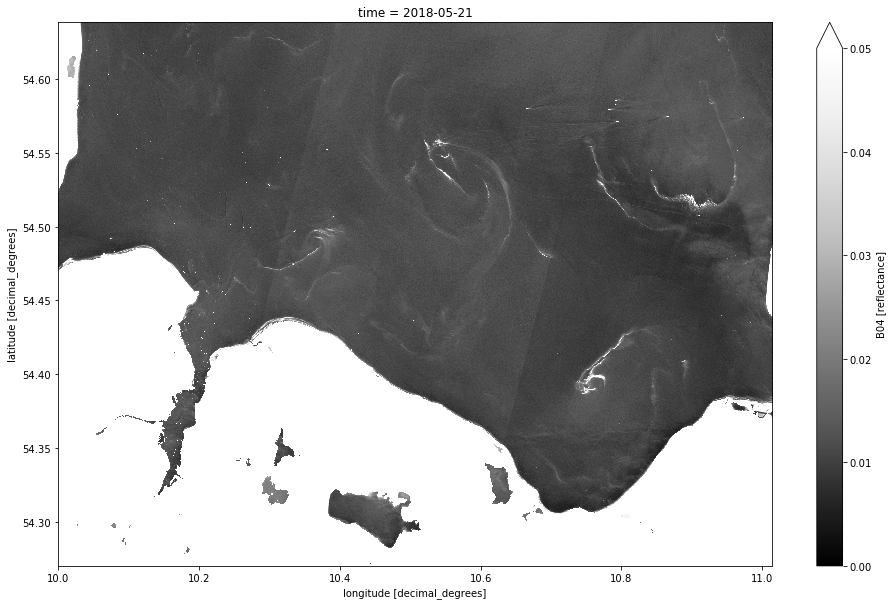

In [21]:
water_cube.B04.sel(time='2018-05-21').plot.imshow(vmin=0, vmax=0.05, cmap='Greys_r', figsize=(16, 10))

In [22]:
request_collector.stats

---

We now compute a Chlorophyll indicator called *Maximum Chlorophyll Index* from bands B04, B05, B06:

In [23]:
b_from = water_cube.B04
b_peek = water_cube.B05
b_to = water_cube.B06

wlen_from = b_from.attrs['wavelength']
wlen_peek = b_peek.attrs['wavelength']
wlen_to = b_to.attrs['wavelength']

f = (wlen_peek - wlen_from) / (wlen_to - wlen_from)
mci = (b_peek - b_from) - f * (b_to - b_from)

mci.attrs['long_name'] = 'Maximum Chlorophyll Index'
mci.attrs['units'] = 'unitless'
mci

<xarray.DataArray (time: 40, lat: 2048, lon: 5632)>
dask.array<sub, shape=(40, 2048, 5632), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
Attributes:
    long_name:  Maximum Chlorophyll Index
    units:      unitless

---

And the well-known *Normalised Difference Vegetation Index*:

In [24]:
veg_cube = cube.where(scene_classif.vegetation)
veg_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 40)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(40, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512

In [25]:
b_red = veg_cube.B04
b_nir = veg_cube.B11
ndvi = (b_nir - b_red) / (b_nir + b_red)
ndvi.attrs['long_name'] = 'Normalized Difference Vegetation Index'
ndvi.attrs['units'] = 'unitless'
ndvi

<xarray.DataArray (time: 40, lat: 2048, lon: 5632)>
dask.array<truediv, shape=(40, 2048, 5632), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
Attributes:
    long_name:  Normalized Difference Vegetation Index
    units:      unitless

In [26]:
my_cube = xr.Dataset({'mci': mci, 'ndvi': ndvi})
my_cube

<xarray.Dataset>
Dimensions:  (lat: 2048, lon: 5632, time: 40)
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
Data variables:
    mci      (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ndvi     (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

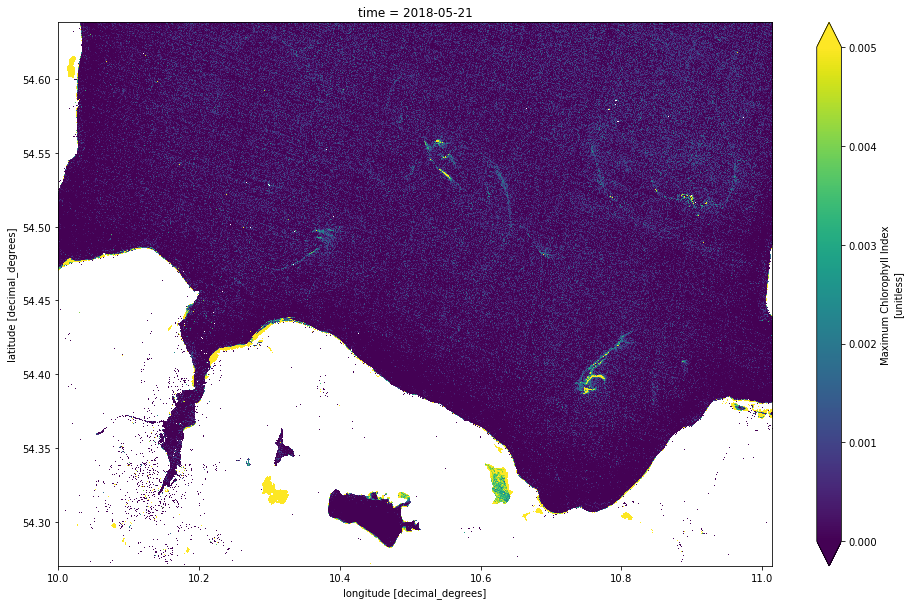

In [27]:
my_cube.mci.isel(time=3).plot.imshow(vmin=0, vmax=0.005, cmap='viridis', figsize=(16, 10))

In [28]:
request_collector.stats

---

Now we are going for a spatial subset within the scene, the lake *Selenter See*: 

In [29]:
geodb = GeoDB()

aoi = geodb.find_feature('S_NAME == "Selenter_See"')

IPython.display.GeoJSON(aoi)

<IPython.display.GeoJSON object>

We are clipping the cube to the polygon and masking "mci" but exclude "ndvi":

In [30]:
my_masked_cube = xcube.api.mask_dataset_by_geometry(my_cube, aoi, no_clip=False, save_geometry_wkt=True, excluded_vars='ndvi')
my_masked_cube

<xarray.Dataset>
Dimensions:  (lat: 230, lon: 739, time: 40)
Coordinates:
  * lat      (lat) float64 54.32 54.32 54.32 54.32 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.38 10.38 10.38 10.38 ... 10.51 10.51 10.51 10.52
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
Data variables:
    mci      (time, lat, lon) float32 dask.array<chunksize=(1, 230, 437), meta=np.ndarray>
    ndvi     (time, lat, lon) float32 dask.array<chunksize=(1, 230, 437), meta=np.ndarray>
Attributes:
    geospatial_lon_min:         10.38214
    geospatial_lon_max:         10.51516
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.0001799999999999998
    geospatial_lat_min:         54.2817
    geospatial_lat_max:         54.323100000000004
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.00018000000000001177
    date_modified:              2019-10-30T14:16:24.838793
    geometry_wkt:               POLYGON Z ((10.3821980

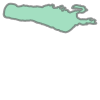

In [31]:
import shapely.wkt
shapely.wkt.loads(my_masked_cube.attrs['geometry_wkt'])

In [32]:
filename = 'my_masked_cube.zarr'
#import shutil
#shutil.rmtree(filename, ignore_errors=True)
#my_masked_cube = my_masked_cube.chunk(chunks=dict(time=1, lat=230, lon=739))
#my_masked_cube.to_zarr(filename)

In [33]:
my_masked_cube = xr.open_zarr(filename)

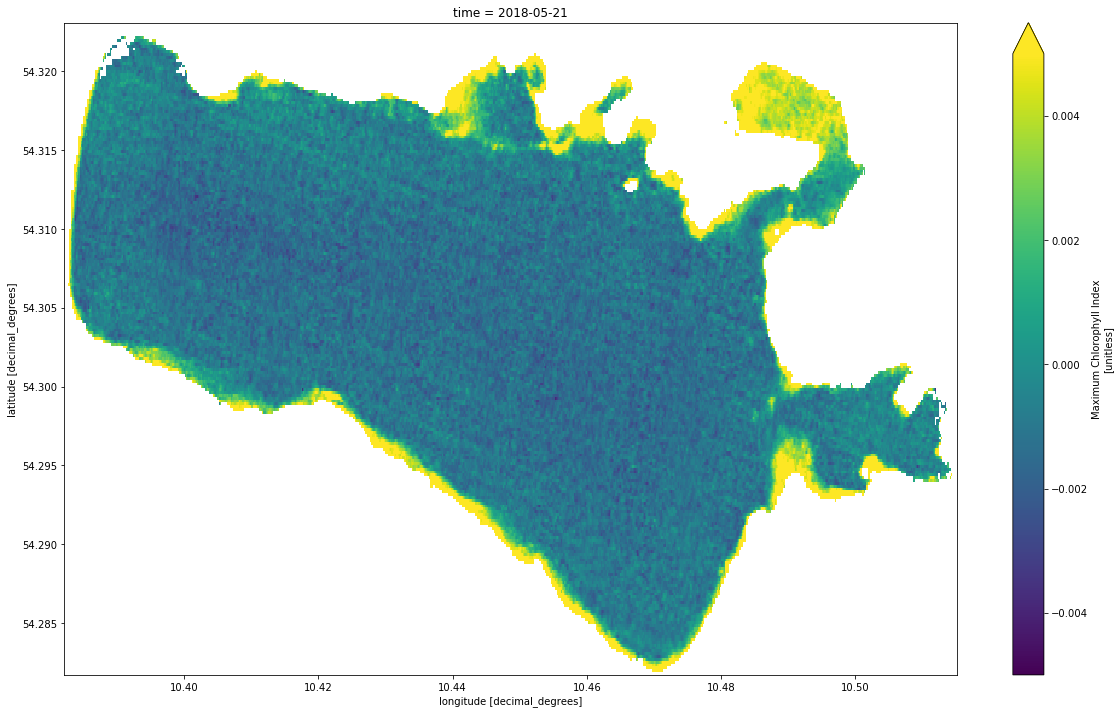

In [34]:
my_masked_cube.mci.sel(time='2018-05-21').plot.imshow(vmin=-0.005, vmax=0.005, cmap='viridis', figsize=(20,12))

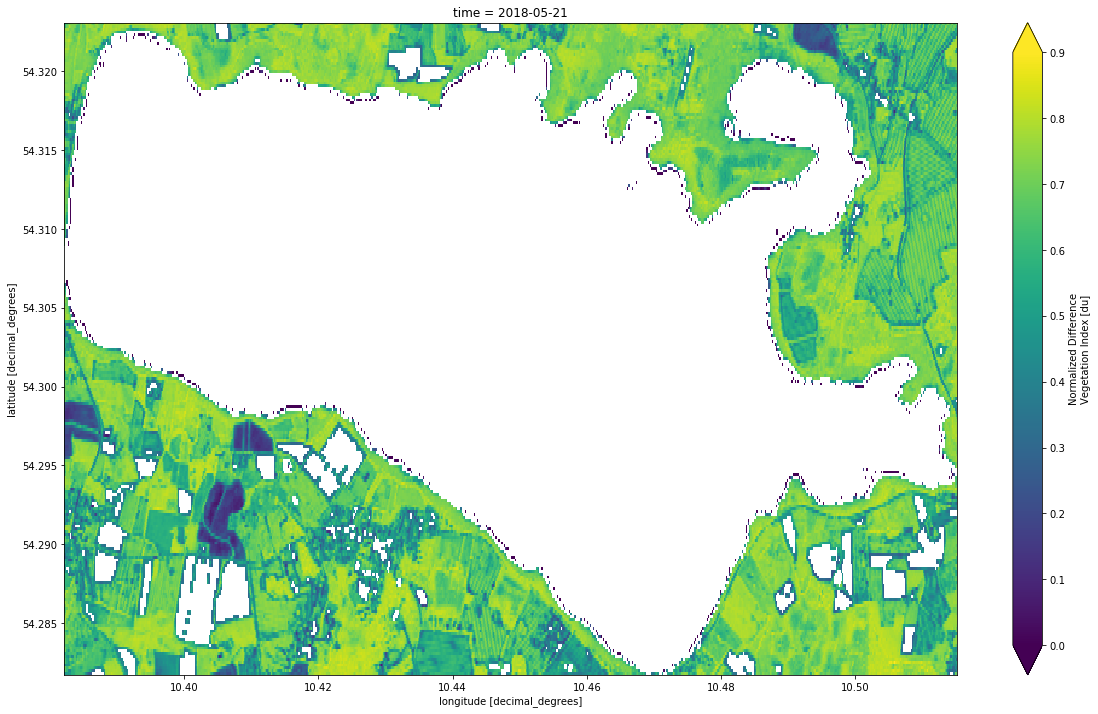

In [35]:
my_masked_cube.ndvi.sel(time='2018-05-21').plot.imshow(vmin=0, vmax=0.9, cmap='viridis', figsize=(20,12))

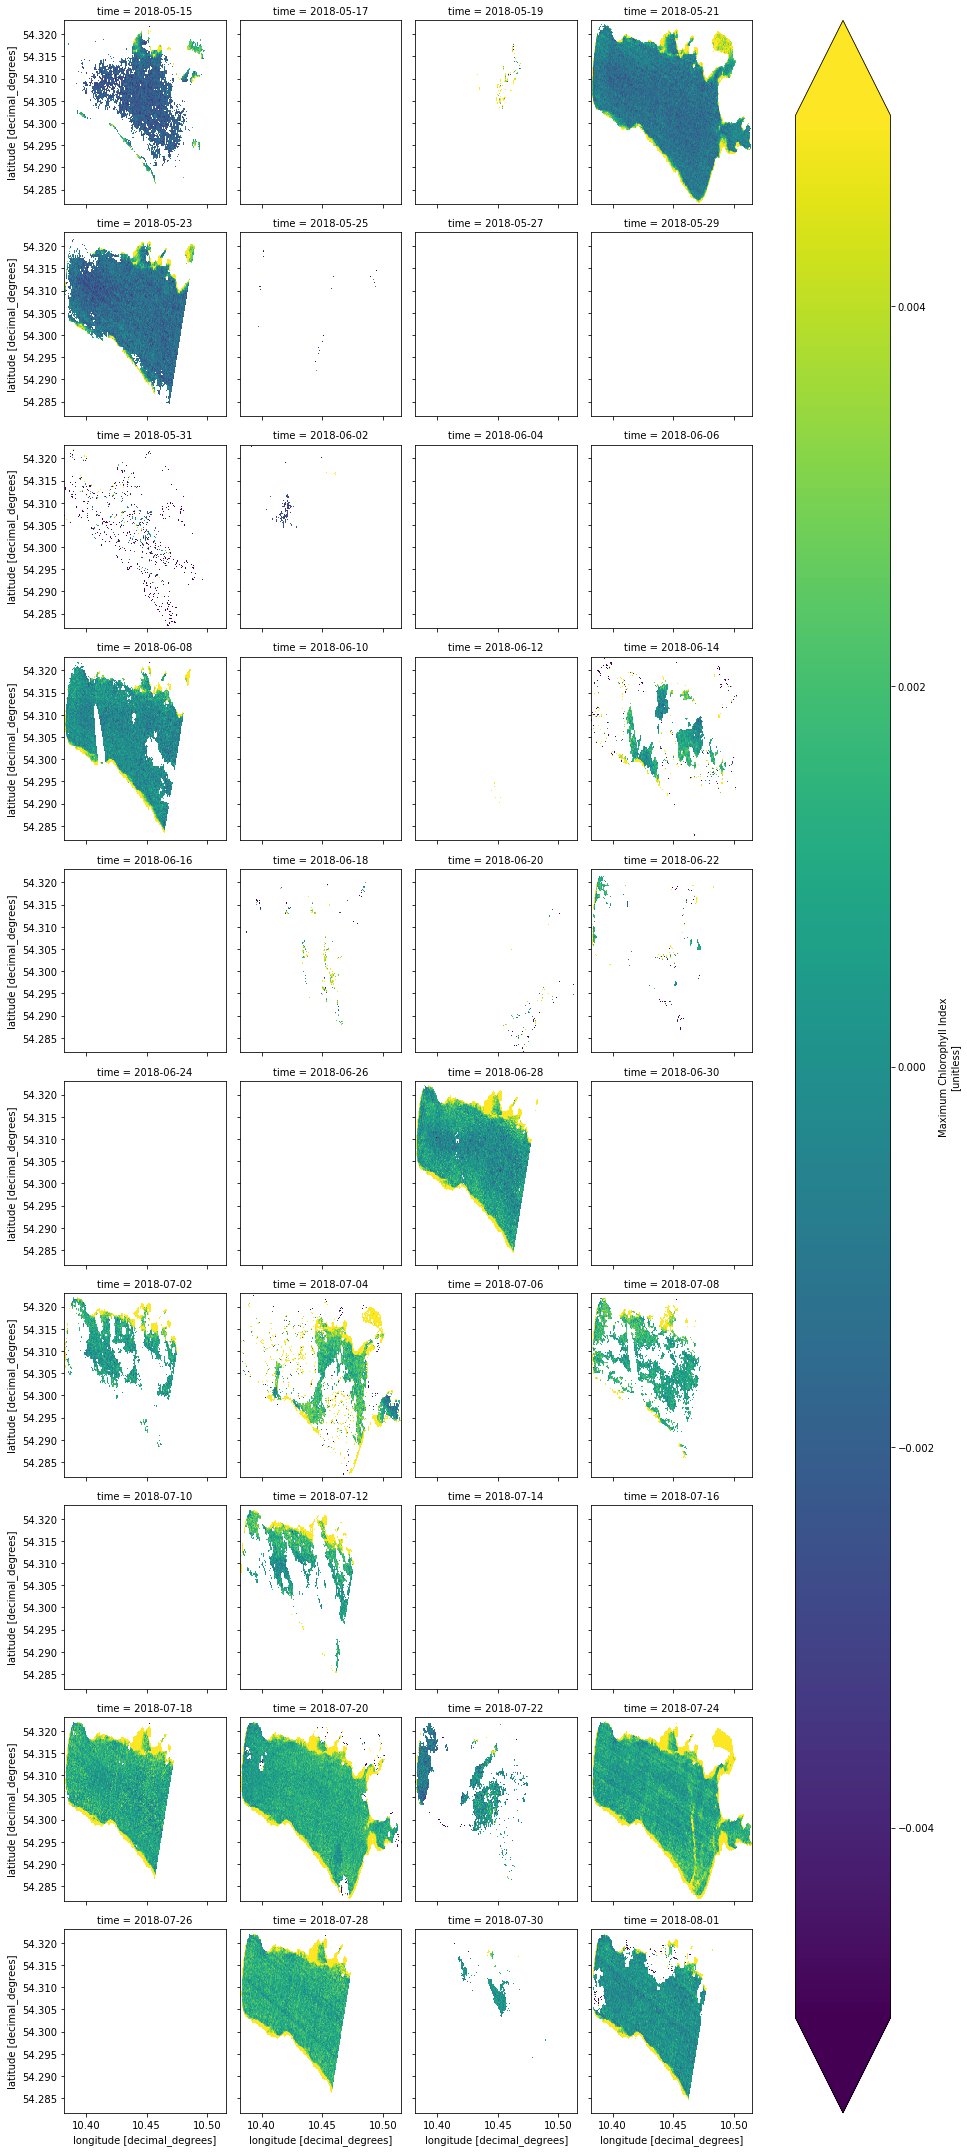

In [36]:
my_masked_cube.mci.plot.imshow(col='time', col_wrap=4, vmin=-0.005, vmax=0.005, cmap='viridis')

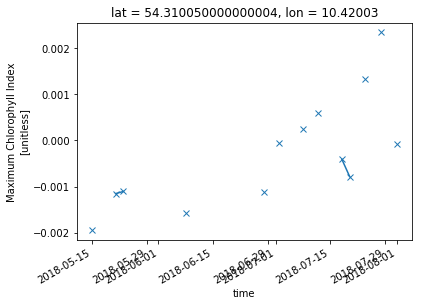

In [37]:
my_masked_cube.mci.sel(lat=54.31, lon=10.42, method='nearest').plot.line(marker='x')

D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


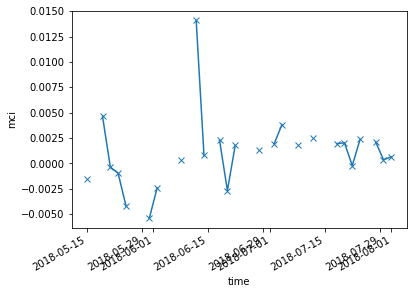

In [38]:
my_masked_cube.mci.mean(dim=('lat', 'lon'), skipna=True).plot.line(marker='x')

In [39]:
mci_mean = my_masked_cube.mci.mean(dim='time')

D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


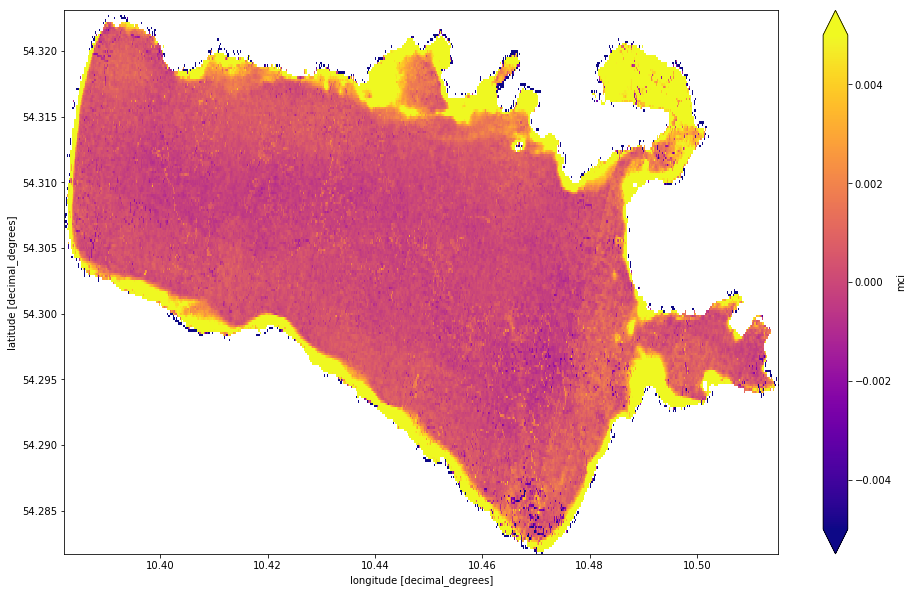

In [40]:
mci_mean.plot.imshow(vmin=-0.005, vmax=0.005, cmap='plasma', figsize=(16,10))

In [41]:
mci_anomaly = my_masked_cube.mci - mci_mean

D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packag

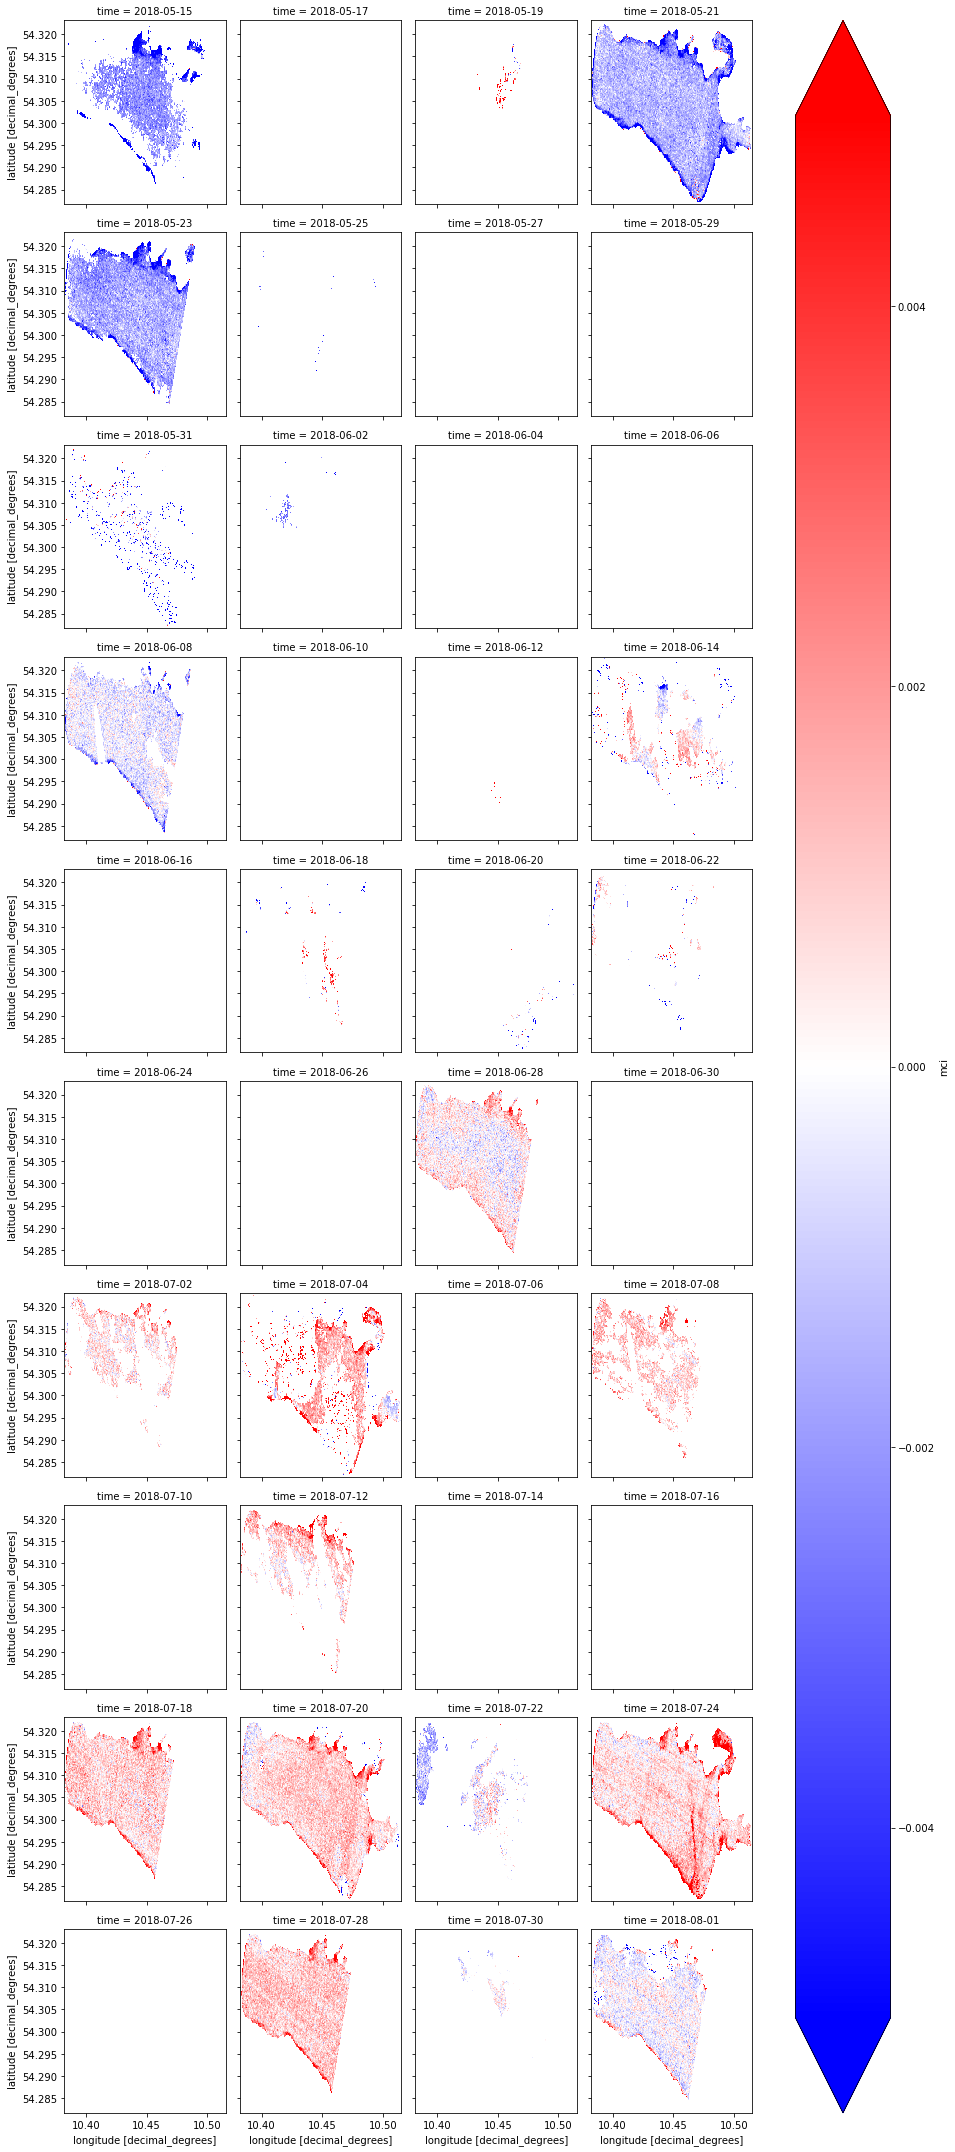

In [42]:
mci_anomaly.plot.imshow(col='time', col_wrap=4, vmin=-0.005, vmax=0.005, cmap='bwr')

---

In [43]:
server = ViewerServer('my_masked_cube.zarr')

running: xcube serve --address 0.0.0.0 my_masked_cube.zarr


In [44]:
server

In [46]:
#server.kill()